In [2]:
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt
import streamlit as st
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, roc_curve, auc
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from sklearn.preprocessing import StandardScaler

In [3]:
#Generate synthetic dataset
data_size = 90000
np.random.seed(42)

In [4]:
df = pd.DataFrame({
    'user_rating': np.random.uniform(1.0, 5.0, data_size),
    'driver_rating': np.random.uniform(1.0, 5.0, data_size),
    'time_of_day': np.random.choice(['morning', 'afternoon', 'evening', 'night'], data_size),
    'ride_demand': np.random.choice(['low', 'medium', 'high'], data_size),
    'past_cancellations': np.random.randint(0, 5, data_size),
    'cancellation': np.random.choice([0, 1], data_size, p=[0.7, 0.3])
})

In [5]:
df.shape

(90000, 6)

In [6]:
df.head()

,user_rating,driver_rating,time_of_day,ride_demand,past_cancellations,cancellation
0,2.498160,4.508637,evening,high,0,1
1,4.802857,4.628690,afternoon,low,2,1
2,3.927976,2.513489,afternoon,high,2,1
3,3.394634,1.926523,evening,high,0,0
4,1.624075,1.766644,evening,low,3,0


In [7]:
print(df['time_of_day'].unique())

['evening' 'afternoon' 'night' 'morning']


In [8]:
# Encode categorical variables
df = pd.get_dummies(df, columns=['time_of_day', 'ride_demand'], drop_first=True)

In [9]:
df.head()

,user_rating,driver_rating,past_cancellations,cancellation,time_of_day_evening,time_of_day_morning,time_of_day_night,ride_demand_low,ride_demand_medium
0,2.498160,4.508637,0,1,True,False,False,False,False
1,4.802857,4.628690,2,1,False,False,False,True,False
2,3.927976,2.513489,2,1,False,False,False,False,False
3,3.394634,1.926523,0,0,True,False,False,False,False
4,1.624075,1.766644,3,0,True,False,False,True,False


In [10]:
# Split dataset
X = df.drop(columns=['cancellation'])
y = df['cancellation']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [11]:
X.head()

,user_rating,driver_rating,past_cancellations,time_of_day_evening,time_of_day_morning,time_of_day_night,ride_demand_low,ride_demand_medium
0,2.498160,4.508637,0,True,False,False,False,False
1,4.802857,4.628690,2,False,False,False,True,False
2,3.927976,2.513489,2,False,False,False,False,False
3,3.394634,1.926523,0,True,False,False,False,False
4,1.624075,1.766644,3,True,False,False,True,False


In [12]:
y.head()

0    1
1    1
2    1
3    0
4    0
Name: cancellation, dtype: int64

In [13]:
# Model training
model = RandomForestClassifier(n_estimators=150, random_state=42)
model.fit(X_train, y_train)

RandomForestClassifier(n_estimators=150, random_state=42)

In [16]:
# Evaluate model
y_prob = model.predict_proba(X_test)[:, 1]
y_prob = np.clip(y_prob, 0, 0.9)  # Restrict probabilities to 0-90%
y_pred = (y_prob >= 0.3).astype(int)  # Adjust threshold
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.5213333333333333
Classification Report:
               precision    recall  f1-score   support

           0       0.71      0.54      0.61     12682
           1       0.30      0.48      0.37      5318

    accuracy                           0.52     18000
   macro avg       0.51      0.51      0.49     18000
weighted avg       0.59      0.52      0.54     18000



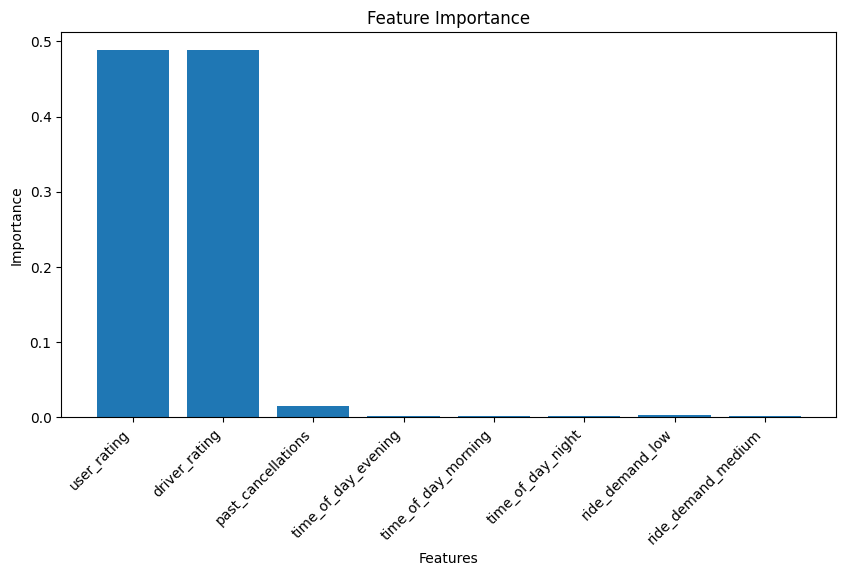

In [18]:
import matplotlib.pyplot as plt

# Get feature importances directly from the RandomForestClassifier
feature_importances = model.feature_importances_

# Plot Feature Importances
plt.figure(figsize=(10, 5))
plt.bar(X.columns, feature_importances)
plt.xticks(rotation=45, ha='right')
plt.title("Feature Importance")
plt.xlabel("Features")
plt.ylabel("Importance")
plt.show()


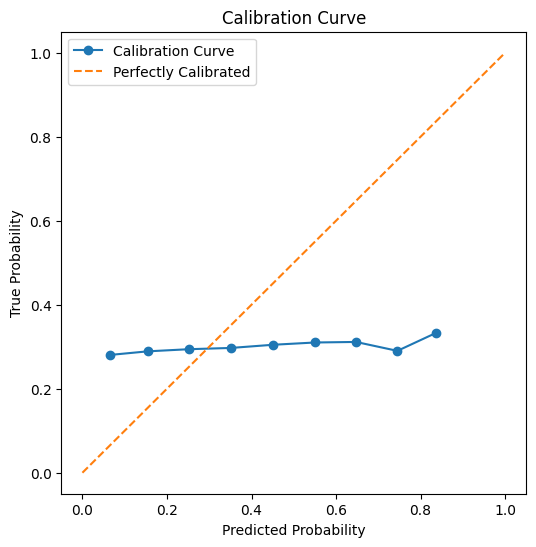

In [19]:
# Calibration Curve
y_true, y_pred_prob = calibration_curve(y_test, y_prob, n_bins=10, strategy='uniform')
plt.figure(figsize=(6, 6))
plt.plot(y_pred_prob, y_true, marker='o', label='Calibration Curve')
plt.plot([0, 1], [0, 1], linestyle='--', label='Perfectly Calibrated')
plt.xlabel("Predicted Probability")
plt.ylabel("True Probability")
plt.title("Calibration Curve")
plt.legend()
plt.show()


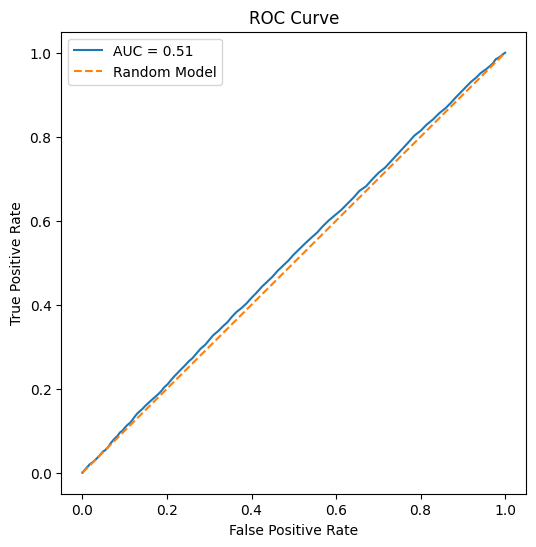

In [20]:
# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], linestyle='--', label='Random Model')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()


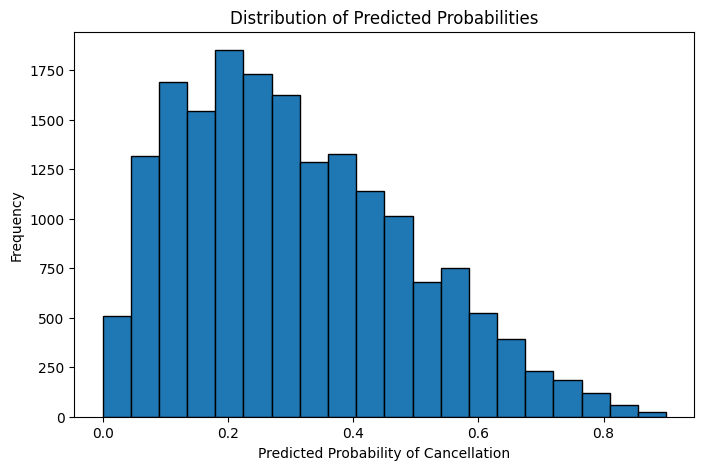

In [21]:
# Prediction Distribution
plt.figure(figsize=(8, 5))
plt.hist(y_prob, bins=20, edgecolor='black')
plt.xlabel("Predicted Probability of Cancellation")
plt.ylabel("Frequency")
plt.title("Distribution of Predicted Probabilities")
plt.show()

In [22]:
df.columns

Index(['user_rating', 'driver_rating', 'past_cancellations', 'cancellation',
       'time_of_day_evening', 'time_of_day_morning', 'time_of_day_night',
       'ride_demand_low', 'ride_demand_medium'],
      dtype='object')

In [23]:
import numpy as np

# Sample input data
input_data = (3.394634,1.926523, 0, True, False, False, False, False)

# Convert input data to a NumPy array
input_data_as_numpy_array = np.asarray(input_data, dtype=np.float32)

# Reshape the array as we are predicting for one instance
input_data_reshaped = input_data_as_numpy_array.reshape(1, -1)

# Make prediction using the trained model
prediction = model.predict(input_data_reshaped)

# Output result
if prediction[0] == 0:
    print("Not Cancelled")
else:
    print("Cancelled")


Not Cancelled


c:\Project_ML\uber\ub\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


In [24]:
prediction

array([0])